In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 69kB/s 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import roc_curve, auc



In [3]:
train = pd.read_csv('/content/drive/MyDrive/train_h.csv')
label = pd.read_csv('/content/drive/MyDrive/label.csv')

In [4]:
train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [5]:
train.shape

(780502, 9)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_id     780502 non-null  object 
 1   product_id   780502 non-null  object 
 2   description  780502 non-null  object 
 3   quantity     780502 non-null  int64  
 4   order_date   780502 non-null  object 
 5   price        780502 non-null  float64
 6   customer_id  780502 non-null  int64  
 7   country      780502 non-null  object 
 8   total        780502 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


In [7]:
train.isna().sum() # 결측치가 없습니다.

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

In [8]:
train.duplicated().value_counts() # 중복 데이터가 없습니다.

False    780502
dtype: int64

In [9]:
train.describe()

,quantity,price,customer_id,total
count,780502.000000,780502.000000,780502.000000,780502.000000
mean,12.623307,6.140931,15313.393466,33.715373
std,143.906302,119.042266,1695.765797,274.207403
min,-74215.000000,0.000000,12346.000000,-127352.940000
25%,2.000000,2.062500,13963.000000,7.260000
50%,5.000000,3.217500,15239.000000,19.470000
75%,12.000000,6.187500,16788.000000,32.175000
max,74215.000000,64300.500000,18287.000000,127352.940000


In [10]:
len(train.customer_id.unique())
# unique한 customer_id는 5914개 입니다.

5914

In [11]:
# order_date를 년- 월로 뽑아내기 위해 year_month라는 함수를 만들어 order_date에 적용했습니다.
def year_month(x) :
  return x[ : 7]

train['year_month'] = train['order_date'].apply(year_month)

In [12]:
# customer_id 를 중복없이 뽑아내서 cust라는 변수에 지정해줬습니다.
cust = train['customer_id'].unique()
cust = pd.DataFrame(cust)
cust = cust.rename(columns = {0 : 'customer_id'})
cust

,customer_id
0,13085
1,13078
2,15362
3,18102
4,12682
...,...
5909,13521
5910,14349
5911,12966
5912,15060


## 월별 토탈합

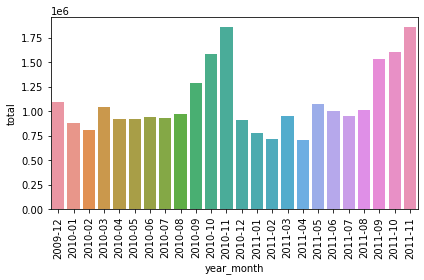

In [13]:
sns.barplot(x = train.groupby('year_month').sum().total.index, y = train.groupby('year_month').sum().total)
plt.xticks(rotation = 90)
plt.tight_layout()

9월 ~ 11월 사이에 토탈합이 높은것을 확인 할 수 있습니다.

## 환불횟수와 구매횟수

In [14]:
# 환불한 사람들을 리스트 a 에 추가
a = []
for i in train.index :
    if train.order_id[i][0] == 'C' :
        a.append(i)

# 환불하지 않은 고객들을 리스트 b에 추가
b = []
for i in train.index :
    if i not in a :
        b.append(i)

train_refund = train.loc[a, :]
train_purchase = train.loc[b, :]

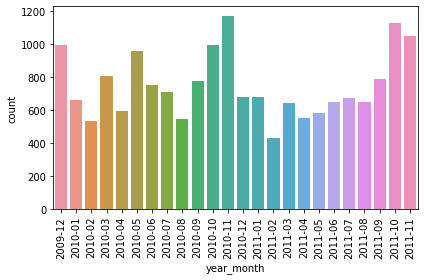

In [15]:
sns.barplot(x = train.groupby('year_month').count().total.index, y = train_refund.groupby('year_month').count().total)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.ylabel('count')
plt.show()

환불량은 9월~ 11월에 공통적으로 많긴 하지만 월마다 연관성이 크게 보이지는 않습니다.

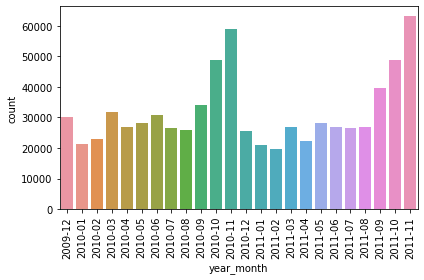

In [16]:
sns.barplot(x = train.groupby('year_month').count().total.index, y = train_purchase.groupby('year_month').count().total)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.ylabel('count')
plt.show()

구매량은 9월 ~ 11월에 높은 것을 확인할 수 있습니다.

9월~ 11월에 환불량이 높은 이유는 9월 ~ 11월에 구매량이 높기 때문이라고 생각 할수도 있을것 같습니다.

## 월별 데이터

In [17]:
d_0912 = train[train['year_month'] == '2009-12']
d_1001 = train[train['year_month'] == '2010-01']
d_1002 = train[train['year_month'] == '2010-02']
d_1003 = train[train['year_month'] == '2010-03']
d_1004 = train[train['year_month'] == '2010-04']
d_1005 = train[train['year_month'] == '2010-05']
d_1006 = train[train['year_month'] == '2010-06']
d_1007 = train[train['year_month'] == '2010-07']
d_1008 = train[train['year_month'] == '2010-08']
d_1009 = train[train['year_month'] == '2010-09']
d_1010 = train[train['year_month'] == '2010-10']
d_1011 = train[train['year_month'] == '2010-11']
d_1012 = train[train['year_month'] == '2010-12']
d_1101 = train[train['year_month'] == '2011-01']
d_1102 = train[train['year_month'] == '2011-02']
d_1103 = train[train['year_month'] == '2011-03']
d_1104 = train[train['year_month'] == '2011-04']
d_1105 = train[train['year_month'] == '2011-05']
d_1106 = train[train['year_month'] == '2011-06']
d_1107 = train[train['year_month'] == '2011-07']
d_1108 = train[train['year_month'] == '2011-08']
d_1109 = train[train['year_month'] == '2011-09']
d_1110 = train[train['year_month'] == '2011-10']
d_1111 = train[train['year_month'] == '2011-11']

## 월별 total 합구해서 cust랑 합치기

In [18]:
d_0912

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12
...,...,...,...,...,...,...,...,...,...,...
31271,493407,21993,FLORAL FOLK STATIONERY SET,1,2009-12-23 16:04:00,4.8675,17867,United Kingdom,4.8675,2009-12
31272,493407,21992,VINTAGE PAISLEY STATIONERY SET,1,2009-12-23 16:04:00,4.8675,17867,United Kingdom,4.8675,2009-12
31273,493407,21991,BOHEMIAN COLLAGE STATIONERY SET,1,2009-12-23 16:04:00,4.8675,17867,United Kingdom,4.8675,2009-12
31274,493407,21034,REX CASH+CARRY JUMBO SHOPPER,10,2009-12-23 16:04:00,1.5675,17867,United Kingdom,15.6750,2009-12


In [19]:
def total_sum(d_month,label_name) :
  total_sum = d_month.groupby('customer_id')['total'].sum()
  for i in total_sum.index :
    cust.loc[cust['customer_id'] == i, label_name] = total_sum[i]
  return cust

In [20]:
total_sum(d_0912, '2009-12t')
total_sum(d_1001, '2010-01t')
total_sum(d_1002, '2010-02t')
total_sum(d_1003, '2010-03t')
total_sum(d_1004, '2010-04t')
total_sum(d_1005, '2010-05t')
total_sum(d_1006, '2010-06t')
total_sum(d_1007, '2010-07t')
total_sum(d_1008, '2010-08t')
total_sum(d_1009, '2010-09t')
total_sum(d_1010, '2010-10t')
total_sum(d_1011, '2010-11t')
total_sum(d_1012, '2010-12t')
total_sum(d_1101, '2011-01t')
total_sum(d_1102, '2011-02t')
total_sum(d_1103, '2011-03t')
total_sum(d_1104, '2011-04t')
total_sum(d_1105, '2011-05t')
total_sum(d_1106, '2011-06t')
total_sum(d_1107, '2011-07t')
total_sum(d_1108, '2011-08t')
total_sum(d_1109, '2011-09t')
total_sum(d_1110, '2011-10t')
total_sum(d_1111, '2011-11t')

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t
0,13085,1809.7200,1518.6600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1369.6980,NaN,NaN,NaN,458.865,NaN,-237.1050,NaN,NaN,227.667,NaN,NaN,NaN,NaN
1,13078,3759.1950,1412.3175,1452.066,2168.4795,1157.1780,1686.5805,2003.0175,1634.3580,2110.3500,1830.5925,2302.7895,4779.3900,1440.8790,1230.8670,553.443,2028.708,1165.0320,748.8525,1281.0930,925.947,1799.919,2467.5750,2317.8870,3190.8360
2,15362,512.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498.8445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18102,67659.4710,63616.2450,36756.885,35004.9315,27384.3075,21737.5125,25326.8730,78781.0815,76752.0435,-267.3000,48799.8060,36452.6415,45927.1065,NaN,17383.542,11400.378,1713.9375,29973.4710,69233.0760,32817.114,1626.768,81876.5970,86924.0955,25296.2820
4,12682,1770.3675,1409.6775,2768.073,1137.5925,1425.0060,979.2585,2070.7830,657.5910,756.8055,1429.0650,817.0800,2239.4955,1774.2285,1377.9315,1652.871,791.010,966.1575,2145.3300,1295.3985,1688.709,1871.232,955.8285,703.8570,3988.7100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,13521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457.8420
5910,14349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.2750
5911,12966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.2970
5912,15060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.1060


In [21]:
# nan값은 0으로 처리해줬습니다.
cust = cust.sort_values('customer_id').fillna(0)

In [22]:
cust

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t
836,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
4012,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000
3577,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000
351,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575
4498,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215
3677,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
1658,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
929,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000


## 라벨만들기

In [23]:
labels = cust.drop('customer_id', axis = 1)
labels

,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t
836,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
4012,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000
3577,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000
351,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575
4498,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215
3677,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
1658,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
929,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000


In [24]:
def target_make(x):
    if x > 300:
        return 1
    else:
        return 0
labels = labels.applymap(target_make)

In [25]:
labels

,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t
836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4012,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0
3577,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0
351,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
3677,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
929,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 기본 데이터 가지고 모델 돌려보기(xgboost 하나만)

In [26]:
data = cust.drop('2011-11t',axis = 1)
target = labels['2011-11t']

In [27]:
data

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t
836,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000
4012,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280
3577,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000
351,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000
4498,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335
3677,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000
1658,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000
929,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000


In [28]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
## 2009 년 12월 ~ 2011년 10월까지 데이터로 2011년 11월의 라벨을 맞추도록 학습을 시키려고 합니다.
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

print('xgb score : ', xgb.score(X_test, y_test))

y_pred=xgb.predict(X_test)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('recall_score : ', recall_score(y_test, y_pred))
print('precision_score : ', precision_score(y_test, y_pred))
print('roc_auc score : ', roc_auc)


## 학습시킨것을 바탕으로 2011년 12월의 라벨을 맞춰보려고 합니다.
test = label['label']
data_pred = xgb.predict(data)
print('xgb score : ', np.mean(test == data_pred))



false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('recall_score : ', recall_score(data_pred, test))
print('precision_score : ',precision_score(data_pred, test))
print('roc_auc score : ',roc_auc)

xgb score :  0.8131868131868132
recall_score :  0.30739299610894943
precision_score :  0.6475409836065574
roc_auc score :  0.6304783555058786
xgb score :  0.8971931011159959
recall_score :  0.36833333333333335
precision_score :  0.4911111111111111
roc_auc score :  0.6626198093087442


## 월별 구매횟수 추가하기

월별 구매횟수와 환불횟수가 토탈에 영향을 미칠 것이라고 생각해서 추가하기로 했습니다.

In [29]:
d_0912p = train_purchase[train_purchase['year_month'] == '2009-12']
d_1001p = train_purchase[train_purchase['year_month'] == '2010-01']
d_1002p = train_purchase[train_purchase['year_month'] == '2010-02']
d_1003p = train_purchase[train_purchase['year_month'] == '2010-03']
d_1004p = train_purchase[train_purchase['year_month'] == '2010-04']
d_1005p = train_purchase[train_purchase['year_month'] == '2010-05']
d_1006p = train_purchase[train_purchase['year_month'] == '2010-06']
d_1007p = train_purchase[train_purchase['year_month'] == '2010-07']
d_1008p = train_purchase[train_purchase['year_month'] == '2010-08']
d_1009p = train_purchase[train_purchase['year_month'] == '2010-09']
d_1010p = train_purchase[train_purchase['year_month'] == '2010-10']
d_1011p = train_purchase[train_purchase['year_month'] == '2010-11']
d_1012p = train_purchase[train_purchase['year_month'] == '2010-12']
d_1101p = train_purchase[train_purchase['year_month'] == '2011-01']
d_1102p = train_purchase[train_purchase['year_month'] == '2011-02']
d_1103p = train_purchase[train_purchase['year_month'] == '2011-03']
d_1104p = train_purchase[train_purchase['year_month'] == '2011-04']
d_1105p = train_purchase[train_purchase['year_month'] == '2011-05']
d_1106p = train_purchase[train_purchase['year_month'] == '2011-06']
d_1107p = train_purchase[train_purchase['year_month'] == '2011-07']
d_1108p = train_purchase[train_purchase['year_month'] == '2011-08']
d_1109p = train_purchase[train_purchase['year_month'] == '2011-09']
d_1110p = train_purchase[train_purchase['year_month'] == '2011-10']
d_1111p = train_purchase[train_purchase['year_month'] == '2011-11']

In [30]:
def purchase(d_month, label_name) :
  purchase = d_month.groupby('customer_id')['total'].count()
  for i in purchase.index :
    cust.loc[cust['customer_id'] == i, label_name] = purchase[i]
  return cust

In [31]:
purchase(d_0912p, '2009-12p')
purchase(d_1001p, '2010-01p')
purchase(d_1002p, '2010-02p')
purchase(d_1003p, '2010-03p')
purchase(d_1004p, '2010-04p')
purchase(d_1005p, '2010-05p')
purchase(d_1006p, '2010-06p')
purchase(d_1007p, '2010-07p')
purchase(d_1008p, '2010-08p')
purchase(d_1009p, '2010-09p')
purchase(d_1010p, '2010-10p')
purchase(d_1011p, '2010-11p')
purchase(d_1012p, '2010-12p')
purchase(d_1101p, '2011-01p')
purchase(d_1102p, '2011-02p')
purchase(d_1103p, '2011-03p')
purchase(d_1104p, '2011-04p')
purchase(d_1105p, '2011-05p')
purchase(d_1106p, '2011-06p')
purchase(d_1107p, '2011-07p')
purchase(d_1108p, '2011-08p')
purchase(d_1109p, '2011-09p')
purchase(d_1110p, '2011-10p')
purchase(d_1111p, '2011-11p')

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t,2009-12p,2010-01p,2010-02p,2010-03p,2010-04p,2010-05p,2010-06p,2010-07p,2010-08p,2010-09p,2010-10p,2010-11p,2010-12p,2011-01p,2011-02p,2011-03p,2011-04p,2011-05p,2011-06p,2011-07p,2011-08p,2011-09p,2011-10p,2011-11p
836,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,5.0,4.0,NaN,5.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4012,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,31.0,29.0,NaN,NaN,24.0,NaN,18.0,NaN,22.0,NaN,47.0,NaN
3577,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,17.0,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
351,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575,NaN,NaN,NaN,NaN,46.0,1.0,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0
4498,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215,NaN,NaN,40.0,79.0,NaN,NaN,NaN,NaN,39.0,NaN,NaN,59.0,NaN,101.0,29.0,NaN,55.0,37.0,100.0,55.0,NaN,47.0,38.0,209.0
3677,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1658,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# nan값은 0으로 처리해줬습니다.
cust = cust.fillna(0)

## 환불횟수 추가하기

In [33]:
d_0912r = train_refund[train_refund['year_month'] == '2009-12']
d_1001r = train_refund[train_refund['year_month'] == '2010-01']
d_1002r = train_refund[train_refund['year_month'] == '2010-02']
d_1003r = train_refund[train_refund['year_month'] == '2010-03']
d_1004r = train_refund[train_refund['year_month'] == '2010-04']
d_1005r = train_refund[train_refund['year_month'] == '2010-05']
d_1006r = train_refund[train_refund['year_month'] == '2010-06']
d_1007r = train_refund[train_refund['year_month'] == '2010-07']
d_1008r = train_refund[train_refund['year_month'] == '2010-08']
d_1009r = train_refund[train_refund['year_month'] == '2010-09']
d_1010r = train_refund[train_refund['year_month'] == '2010-10']
d_1011r = train_refund[train_refund['year_month'] == '2010-11']
d_1012r = train_refund[train_refund['year_month'] == '2010-12']
d_1101r = train_refund[train_refund['year_month'] == '2011-01']
d_1102r = train_refund[train_refund['year_month'] == '2011-02']
d_1103r = train_refund[train_refund['year_month'] == '2011-03']
d_1104r = train_refund[train_refund['year_month'] == '2011-04']
d_1105r = train_refund[train_refund['year_month'] == '2011-05']
d_1106r = train_refund[train_refund['year_month'] == '2011-06']
d_1107r = train_refund[train_refund['year_month'] == '2011-07']
d_1108r = train_refund[train_refund['year_month'] == '2011-08']
d_1109r = train_refund[train_refund['year_month'] == '2011-09']
d_1110r = train_refund[train_refund['year_month'] == '2011-10']
d_1111r = train_refund[train_refund['year_month'] == '2011-11']

In [34]:
def refund(d_month, label_name) :
  refund = d_month.groupby('customer_id')['total'].count()
  for i in refund.index :
    cust.loc[cust['customer_id'] == i, label_name] = refund[i]
  return cust

In [35]:
refund(d_0912r, '2009-12r')
refund(d_1001r, '2010-01r')
refund(d_1002r, '2010-02r')
refund(d_1003r, '2010-03r')
refund(d_1004r, '2010-04r')
refund(d_1005r, '2010-05r')
refund(d_1006r, '2010-06r')
refund(d_1007r, '2010-07r')
refund(d_1008r, '2010-08r')
refund(d_1009r, '2010-09r')
refund(d_1010r, '2010-10r')
refund(d_1011r, '2010-11r')
refund(d_1012r, '2010-12r')
refund(d_1101r, '2011-01r')
refund(d_1102r, '2011-02r')
refund(d_1103r, '2011-03r')
refund(d_1104r, '2011-04r')
refund(d_1105r, '2011-05r')
refund(d_1106r, '2011-06r')
refund(d_1107r, '2011-07r')
refund(d_1108r, '2011-08r')
refund(d_1109r, '2011-09r')
refund(d_1110r, '2011-10r')
refund(d_1111r, '2011-11r')

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t,2009-12p,2010-01p,2010-02p,2010-03p,2010-04p,2010-05p,2010-06p,2010-07p,2010-08p,2010-09p,2010-10p,2010-11p,2010-12p,2011-01p,2011-02p,2011-03p,2011-04p,2011-05p,2011-06p,2011-07p,2011-08p,2011-09p,2011-10p,2011-11p,2009-12r,2010-01r,2010-02r,2010-03r,2010-04r,2010-05r,2010-06r,2010-07r,2010-08r,2010-09r,2010-10r,2010-11r,2010-12r,2011-01r,2011-02r,2011-03r,2011-04r,2011-05r,2011-06r,2011-07r,2011-08r,2011-09r,2011-10r,2011-11r
836,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,5.0,4.0,0.0,5.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4012,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,31.0,29.0,0.0,0.0,24.0,0.0,18.0,0.0,22.0,0.0,47.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,17.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4498,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215,0.0,0.0,40.0,79.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,59.0,0.0,101.0,29.0,0.0,55.0,37.0,100.0,55.0,0.0,47.0,38.0,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3677,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1658,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242

In [36]:
# nan값은 0으로 처리해줬습니다.
cust = cust.fillna(0)

## country

In [37]:
train.groupby(['customer_id','country']).count()

,,order_id,product_id,description,quantity,order_date,price,total,year_month
customer_id,country,,,,,,,,
12346,United Kingdom,47,47,47,47,47,47,47,47
12347,Iceland,211,211,211,211,211,211,211,211
12348,Finland,51,51,51,51,51,51,51,51
12349,Italy,180,180,180,180,180,180,180,180
12350,Norway,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...
18283,United Kingdom,888,888,888,888,888,888,888,888
18284,United Kingdom,29,29,29,29,29,29,29,29
18285,United Kingdom,12,12,12,12,12,12,12,12


customer_id 의 갯수는 5914개 인데 customer_id와 country로 groupby를 한 결과 5927행이 나왔습니다. 이를 봤을 때 국적이 바뀐 고객이 있음을 알 수 있습니다.

따라서 country를 get_dummies 를 통해 더미화한후 고객별로 country를 추가하려고 합니다.


In [38]:
train_1 = train.copy()

In [39]:
train_1 = pd.concat([train_1, pd.get_dummies(train.country)], axis = 1)
# country를 get_dummies 한뒤 train_1과 합쳐줍니다.

In [40]:
train_1

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Korea,Lebanon,Lithuania,Malta,Netherlands,Nigeria,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified,West Indies
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,2009-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,2009-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,2009-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,2009-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [41]:
train_g = train_1.groupby('customer_id').max()

In [42]:
train_g

,order_id,product_id,description,quantity,order_date,price,country,total,year_month,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Korea,Lebanon,Lithuania,Malta,Netherlands,Nigeria,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified,West Indies
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,C541433,TEST002,This is a test product.,74215,2011-01-18 10:17:00,234.8115,United Kingdom,127352.9400,2011-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12347,573511,85232D,WRAP WEDDING DAY,240,2011-10-31 12:25:00,21.0375,Iceland,411.8400,2011-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,568172,POST,SWEETIES STICKERS,144,2011-09-25 13:13:00,66.0000,Finland,396.0000,2011-09,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12349,C490283,POST,ZINC FOLKART SLEIGH BELLS,48,2011-11-21 09:51:00,495.0000,Italy,495.0000,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12350,543037,POST,UNION JACK FLAG PASSPORT COVER,24,2011-02-02 16:01:00,66.0000,Norway,66.0000,2011-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,579673,M,ZINC METAL HEART DECORATION,13,2011-11-30 12:59:00,26.3175,United Kingdom,36.1350,2011-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18284,C525695,C2,WHITE CHRISTMAS TREE DECORATION,50,2010-10-06 12:31:00,82.5000,United Kingdom,82.5000,2010-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18285,498149,C2,WHITE HANGING BEADS CANDLE HOLDER,80,2010-02-17 10:24:00,82.5000,United Kingdom,336.6000,2010-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [43]:
train_g = train_g.drop(['order_id','product_id','description','quantity','order_date','price','country', 'total','year_month'], axis =1)
cust = cust.merge(train_g, on = 'customer_id', how = 'outer')

In [44]:
cust

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2011-11t,2009-12p,2010-01p,2010-02p,2010-03p,2010-04p,2010-05p,2010-06p,2010-07p,2010-08p,2010-09p,2010-10p,2010-11p,2010-12p,2011-01p,2011-02p,...,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Korea,Lebanon,Lithuania,Malta,Netherlands,Nigeria,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified,West Indies
0,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,5.0,4.0,0.0,5.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,31.0,29.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,17.0,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215,0.0,0.0,40.0,79.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,59.0,0.0,101.0,29.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5910,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5911,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5912,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [45]:
cust.columns

Index(['customer_id', '2009-12t', '2010-01t', '2010-02t', '2010-03t',
       '2010-04t', '2010-05t', '2010-06t', '2010-07t', '2010-08t',
       ...
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'USA',
       'United Arab Emirates', 'United Kingdom', 'Unspecified', 'West Indies'],
      dtype='object', length=114)

## 모델

In [46]:
models = {
    'catboost' : CatBoostClassifier(),
    'Xgboost' : XGBClassifier(),
    'lightgbm' : LGBMClassifier(),
    'Gradient boosting' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'KNearest' : KNeighborsClassifier(),
    'Random Forest' : RandomForestClassifier()
}
print(models.items())

dict_items([('catboost', <catboost.core.CatBoostClassifier object at 0x7f9af02b5150>), ('Xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)), ('lightgbm', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, s

In [47]:
data = cust.drop(['2011-11t', '2011-11p', '2011-11r'], axis = 1)
target = labels['2011-11t']


for key, classifier in models.items() :
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
  model = classifier
  model.fit(X_train, y_train)
  print(key)
  print('Trainning : ','ACC : ', round(model.score(X_test, y_test), 4) * 100, '%')
  y_pred = model.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Trainning : ', 'recall_score : ', round(recall_score(y_test,y_pred), 4)*100,'%')
  print('Trainning : ', 'precision_score : ', round(precision_score(y_test,y_pred), 4)*100,'%')
  print('Trainning : ', 'roc_auc_socre : ', round(roc_auc, 4)*100,'%')

  test = label['label']
  data_pred = model.predict(data)
  print('Test : ', 'ACC : ', round(np.mean(test == data_pred),4)*100, '%')
  false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Test : ', 'recall_score : ', round(recall_score(data_pred, test), 4)*100,'%')
  print('Test : ', 'precision_score : ', round(precision_score(data_pred, test), 4)*100,'%')
  print('Test : ', 'roc_auc_score : ', round(roc_auc, 4)*100,'%')
  print('-'*100)

Learning rate set to 0.020005
0:	learn: 0.6826413	total: 63.9ms	remaining: 1m 3s
1:	learn: 0.6716924	total: 76.5ms	remaining: 38.1s
2:	learn: 0.6622981	total: 88.4ms	remaining: 29.4s
3:	learn: 0.6530845	total: 103ms	remaining: 25.5s
4:	learn: 0.6441379	total: 117ms	remaining: 23.3s
5:	learn: 0.6351597	total: 131ms	remaining: 21.8s
6:	learn: 0.6267300	total: 143ms	remaining: 20.3s
7:	learn: 0.6188815	total: 155ms	remaining: 19.2s
8:	learn: 0.6113190	total: 167ms	remaining: 18.4s
9:	learn: 0.6037489	total: 179ms	remaining: 17.7s
10:	learn: 0.5962177	total: 191ms	remaining: 17.2s
11:	learn: 0.5892757	total: 207ms	remaining: 17s
12:	learn: 0.5837120	total: 225ms	remaining: 17.1s
13:	learn: 0.5779858	total: 240ms	remaining: 16.9s
14:	learn: 0.5717773	total: 252ms	remaining: 16.5s
15:	learn: 0.5662496	total: 264ms	remaining: 16.2s
16:	learn: 0.5611802	total: 276ms	remaining: 15.9s
17:	learn: 0.5554635	total: 289ms	remaining: 15.8s
18:	learn: 0.5503401	total: 301ms	remaining: 15.5s
19:	learn:

Xgboost가 가장 높은 rou_auc 스코어가 나왔기 때문에 xgb의 변수 중요도를 확인해 보려고 합니다.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

print('xgb score : ', xgb.score(X_test, y_test))

y_pred=xgb.predict(X_test)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('recall_score : ', recall_score(y_test, y_pred))
print('precision_score : ', precision_score(y_test, y_pred))
print('roc_auc score : ', roc_auc)



test = label['label']
data_pred = xgb.predict(data)
print('xgb score : ', np.mean(test == data_pred))



false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('recallscore : ', recall_score(data_pred, test))
print('precisionscore : ',precision_score(data_pred, test))
print('roc_auc scoer : ',roc_auc)

xgb score :  0.8131868131868132
recall_score :  0.311284046692607
precision_score :  0.6451612903225806
roc_auc score :  0.6318839239942516
xgb score :  0.8939803855258708
recallscore :  0.357487922705314
precisionscore :  0.49333333333333335
roc_auc scoer :  0.6572060811334997


In [49]:
xgb.feature_importances_

array([0.00777732, 0.0123501 , 0.00332068, 0.01854341, 0.02763865,
       0.01326717, 0.00799479, 0.00702772, 0.00506448, 0.01017201,
       0.01055224, 0.00445303, 0.06198078, 0.03137528, 0.01260095,
       0.00722533, 0.00841584, 0.0145675 , 0.01665214, 0.03023485,
       0.01206503, 0.05485975, 0.06374428, 0.02972172, 0.01732124,
       0.01303755, 0.01296034, 0.01311498, 0.00423751, 0.00761508,
       0.01102301, 0.00971405, 0.00956836, 0.01082529, 0.02452617,
       0.01685995, 0.0096489 , 0.01083209, 0.00592682, 0.01189486,
       0.00796346, 0.02095558, 0.03910114, 0.05142218, 0.02023552,
       0.05845575, 0.01586936, 0.01064605, 0.00248513, 0.00586777,
       0.00896796, 0.00618862, 0.00738403, 0.00521469, 0.0050467 ,
       0.        , 0.        , 0.        , 0.00936758, 0.        ,
       0.        , 0.01148059, 0.01350935, 0.        , 0.01213707,
       0.        , 0.        , 0.00924977, 0.00623366, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [50]:
data_feature = []
for i in zip(data.iloc[:,:-1], xgb.feature_importances_) :
  data_feature.append(i)

In [51]:
data_feature

[('customer_id', 0.0077773156),
 ('2009-12t', 0.012350098),
 ('2010-01t', 0.0033206819),
 ('2010-02t', 0.018543411),
 ('2010-03t', 0.02763865),
 ('2010-04t', 0.013267169),
 ('2010-05t', 0.007994792),
 ('2010-06t', 0.0070277215),
 ('2010-07t', 0.0050644786),
 ('2010-08t', 0.010172007),
 ('2010-09t', 0.010552242),
 ('2010-10t', 0.004453029),
 ('2010-11t', 0.061980776),
 ('2010-12t', 0.031375278),
 ('2011-01t', 0.012600954),
 ('2011-02t', 0.0072253295),
 ('2011-03t', 0.008415838),
 ('2011-04t', 0.014567496),
 ('2011-05t', 0.01665214),
 ('2011-06t', 0.030234845),
 ('2011-07t', 0.012065027),
 ('2011-08t', 0.05485975),
 ('2011-09t', 0.063744284),
 ('2011-10t', 0.02972172),
 ('2009-12p', 0.017321238),
 ('2010-01p', 0.01303755),
 ('2010-02p', 0.012960335),
 ('2010-03p', 0.0131149795),
 ('2010-04p', 0.0042375107),
 ('2010-05p', 0.0076150764),
 ('2010-06p', 0.011023008),
 ('2010-07p', 0.00971405),
 ('2010-08p', 0.0095683625),
 ('2010-09p', 0.0108252885),
 ('2010-10p', 0.024526173),
 ('2010-11p',

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110],
 <a list of 111 Text major ticklabel objects>)

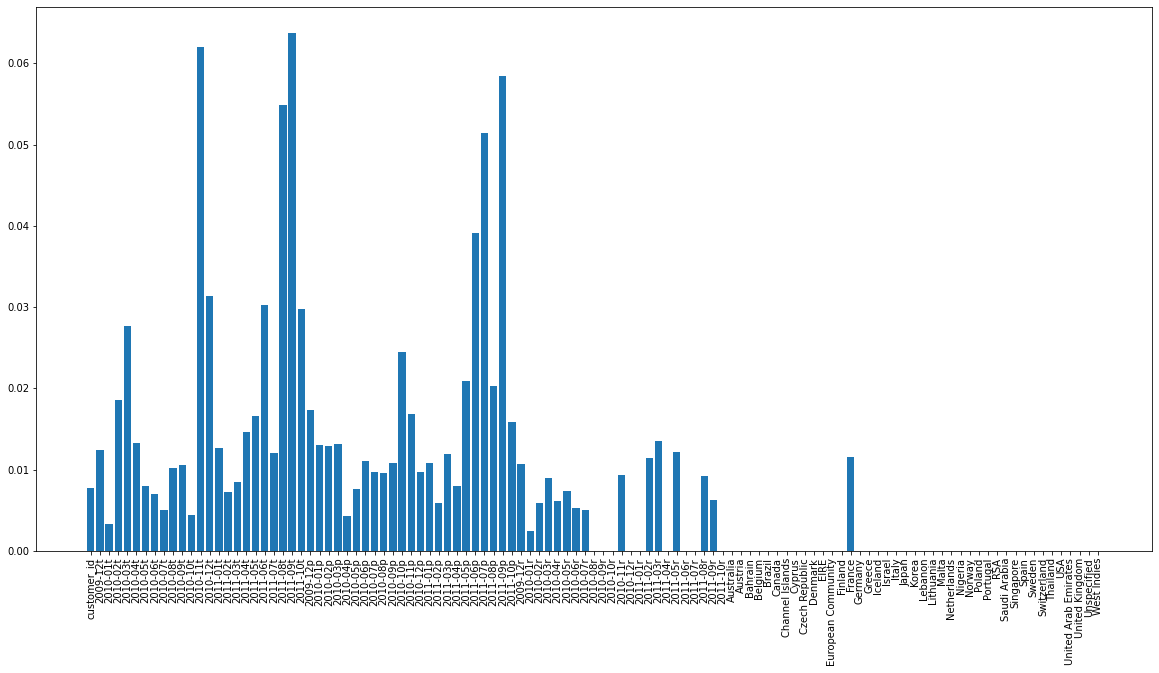

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data.columns, xgb.feature_importances_)
plt.xticks(rotation = 90)

country 변수들이 중요도가 거의 없는것이 보여서 country변수를 빼고 다시 모델을 학습해보려고 합니다.

In [53]:
pd.Series(train.country.values).unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Netherlands', 'Poland',
       'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland',
       'Switzerland', 'Unspecified', 'Nigeria', 'Malta', 'RSA',
       'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Lebanon',
       'Saudi Arabia', 'Czech Republic', 'European Community'],
      dtype=object)

In [54]:
data = cust.drop(['2011-11t', '2011-11p', '2011-11r','United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Netherlands', 'Poland',
       'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland',
       'Switzerland', 'Unspecified', 'Nigeria', 'Malta', 'RSA',
       'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Lebanon',
       'Saudi Arabia', 'Czech Republic', 'European Community'], axis = 1)
target = labels['2011-11t']


for key, classifier in models.items() :
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
  model = classifier
  model.fit(X_train, y_train)
  print(key)
  print('Trainning : ','ACC : ', model.score(X_test, y_test))
  y_pred = model.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Trainning : ', 'recall_score : ', round(recall_score(y_test,y_pred).mean(), 4)*100,'%')
  print('Trainning : ', 'precision_score : ', round(precision_score(y_test,y_pred).mean(), 4)*100,'%')
  print('Trainning : ', 'roc_auc_socre : ', round(roc_auc.mean(), 4)*100,'%')

  test = label['label']
  data_pred = model.predict(data)
  print('Test : ', 'ACC : ', np.mean(test == data_pred))
  false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Test : ', 'recall_score : ', round(recall_score(data_pred, test).mean(), 4)*100,'%')
  print('Test : ', 'precision_score : ', round(precision_score(data_pred, test).mean(), 4)*100,'%')
  print('Test : ', 'roc_auc_score : ', round(roc_auc.mean(), 4)*100,'%')
  print('-'*100)

Learning rate set to 0.020005
0:	learn: 0.6816624	total: 13.2ms	remaining: 13.2s
1:	learn: 0.6719832	total: 24.9ms	remaining: 12.4s
2:	learn: 0.6623095	total: 39.7ms	remaining: 13.2s
3:	learn: 0.6524408	total: 55.6ms	remaining: 13.8s
4:	learn: 0.6438872	total: 67.6ms	remaining: 13.4s
5:	learn: 0.6346322	total: 79.5ms	remaining: 13.2s
6:	learn: 0.6266726	total: 91.3ms	remaining: 13s
7:	learn: 0.6180500	total: 103ms	remaining: 12.8s
8:	learn: 0.6104960	total: 115ms	remaining: 12.6s
9:	learn: 0.6034395	total: 128ms	remaining: 12.7s
10:	learn: 0.5968529	total: 140ms	remaining: 12.6s
11:	learn: 0.5902659	total: 151ms	remaining: 12.5s
12:	learn: 0.5836659	total: 163ms	remaining: 12.4s
13:	learn: 0.5774064	total: 178ms	remaining: 12.5s
14:	learn: 0.5712994	total: 190ms	remaining: 12.5s
15:	learn: 0.5656106	total: 205ms	remaining: 12.6s
16:	learn: 0.5602998	total: 216ms	remaining: 12.5s
17:	learn: 0.5550104	total: 228ms	remaining: 12.4s
18:	learn: 0.5502491	total: 240ms	remaining: 12.4s
19:	le

country 변수를 빼니 Xgboost 의 roc_auc score 가 오른것을 확인할 수 있습니다.

하지만 토탈 합 변수만 넣고 모델학습을 시킨것 보다 낮게 나왔습니다.


## country 새롭게 접근하기

country의 대부분이 United Kingdom 이기 때문에 United Kingdom은 0 나머지는 1로 바꿔준뒤 모델학습을 진행해 보려고 합니다.

In [55]:
train.country.value_counts()

United Kingdom          700317
Germany                  16999
EIRE                     15694
France                   13557
Netherlands               5051
Spain                     3683
Switzerland               3058
Belgium                   3012
Portugal                  2312
Australia                 1890
Channel Islands           1640
Italy                     1499
Sweden                    1341
Norway                    1235
Cyprus                    1153
Finland                   1035
Austria                    931
Denmark                    786
Greece                     627
Japan                      557
Poland                     527
Unspecified                521
USA                        492
United Arab Emirates       386
Singapore                  346
Israel                     321
Malta                      294
Canada                     228
Iceland                    211
Lithuania                  154
RSA                        123
Brazil                      94
Thailand

In [56]:
train2 = train.copy()
train2['country_1'] = 1
train2.loc[train.country.isin(['United Kingdom']), 'country_1'] = 0

In [57]:
country = pd.pivot_table(train2, index = 'customer_id', columns = 'country_1', values = 'price', aggfunc = 'count')
country

country_1,0,1
customer_id,,
12346,47.0,NaN
12347,NaN,211.0
12348,NaN,51.0
12349,NaN,180.0
12350,NaN,17.0
...,...,...
18283,888.0,NaN
18284,29.0,NaN
18285,12.0,NaN


In [58]:
country = country.fillna(0)
country = country.applymap(lambda x : 1 if x>0 else 0)
country

country_1,0,1
customer_id,,
12346,1,0
12347,0,1
12348,0,1
12349,0,1
12350,0,1
...,...,...
18283,1,0
18284,1,0
18285,1,0


In [59]:
# country를 data와 merge해줍니다.
data = data.merge(country, on = 'customer_id', how = 'outer')

In [60]:
data = data.rename(columns = {0 : 'Others', 1 : 'United Kingdom'})
data

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2009-12p,2010-01p,2010-02p,2010-03p,2010-04p,2010-05p,2010-06p,2010-07p,2010-08p,2010-09p,2010-10p,2010-11p,2010-12p,2011-01p,2011-02p,2011-03p,2011-04p,2011-05p,2011-06p,2011-07p,2011-08p,2011-09p,2011-10p,2009-12r,2010-01r,2010-02r,2010-03r,2010-04r,2010-05r,2010-06r,2010-07r,2010-08r,2010-09r,2010-10r,2010-11r,2010-12r,2011-01r,2011-02r,2011-03r,2011-04r,2011-05r,2011-06r,2011-07r,2011-08r,2011-09r,2011-10r,Others,United Kingdom
0,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,5.0,4.0,0.0,5.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,31.0,29.0,0.0,0.0,24.0,0.0,18.0,0.0,22.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,17.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,0.0,0.0,40.0,79.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,59.0,0.0,101.0,29.0,0.0,55.0,37.0,100.0,55.0,0.0,47.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
5910,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
5911,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
5912,18286,763.8675,0.000,0.000,0.0000,0.000,0.0000,-178.2000,0.0,1375.242,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,17.0,0.0,0.0,0.0,0.0,0.0,0

In [61]:
for key, classifier in models.items() :
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
  model = classifier
  model.fit(X_train, y_train)
  print(key)
  print('Trainning : ','ACC : ', model.score(X_test, y_test))
  y_pred = model.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Trainning : ', 'recall_score : ', round(recall_score(y_test,y_pred).mean(), 4)*100,'%')
  print('Trainning : ', 'precision_score : ', round(precision_score(y_test,y_pred).mean(), 4)*100,'%')
  print('Trainning : ', 'roc_auc_socre : ', round(roc_auc.mean(), 4)*100,'%')

  test = label['label']
  data_pred = model.predict(data)
  print('Test : ', 'ACC : ', np.mean(test == data_pred))
  false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Test : ', 'recall_score : ', round(recall_score(data_pred, test).mean(), 4)*100,'%')
  print('Test : ', 'precision_score : ', round(precision_score(data_pred, test).mean(), 4)*100,'%')
  print('Test : ', 'roc_auc_score : ', round(roc_auc.mean(), 4)*100,'%')
  print('-'*100)

Learning rate set to 0.020005
0:	learn: 0.6821084	total: 12.9ms	remaining: 12.9s
1:	learn: 0.6723494	total: 25.1ms	remaining: 12.5s
2:	learn: 0.6621879	total: 37.2ms	remaining: 12.4s
3:	learn: 0.6522786	total: 49.7ms	remaining: 12.4s
4:	learn: 0.6441358	total: 62.2ms	remaining: 12.4s
5:	learn: 0.6350358	total: 74ms	remaining: 12.3s
6:	learn: 0.6261747	total: 85.4ms	remaining: 12.1s
7:	learn: 0.6179842	total: 97.2ms	remaining: 12.1s
8:	learn: 0.6106932	total: 109ms	remaining: 12s
9:	learn: 0.6032572	total: 120ms	remaining: 11.9s
10:	learn: 0.5962052	total: 132ms	remaining: 11.8s
11:	learn: 0.5895446	total: 143ms	remaining: 11.8s
12:	learn: 0.5830237	total: 155ms	remaining: 11.8s
13:	learn: 0.5769355	total: 167ms	remaining: 11.7s
14:	learn: 0.5708376	total: 178ms	remaining: 11.7s
15:	learn: 0.5651432	total: 192ms	remaining: 11.8s
16:	learn: 0.5595937	total: 212ms	remaining: 12.3s
17:	learn: 0.5541259	total: 228ms	remaining: 12.4s
18:	learn: 0.5493116	total: 240ms	remaining: 12.4s
19:	lea

이번엔 country를 라벨인코딩 하여 월별로 고객의 country변수를 추가해주려고 합니다.

In [62]:
train_3 = train.copy()
from sklearn.preprocessing import LabelEncoder
Labelencoder = LabelEncoder()
train_3['country'] = Labelencoder.fit_transform(train_3['country'])

In [63]:
d_0912c = train_3[train_3['year_month'] == '2009-12']
d_1001c = train_3[train_3['year_month'] == '2010-01']
d_1002c = train_3[train_3['year_month'] == '2010-02']
d_1003c = train_3[train_3['year_month'] == '2010-03']
d_1004c = train_3[train_3['year_month'] == '2010-04']
d_1005c = train_3[train_3['year_month'] == '2010-05']
d_1006c = train_3[train_3['year_month'] == '2010-06']
d_1007c = train_3[train_3['year_month'] == '2010-07']
d_1008c = train_3[train_3['year_month'] == '2010-08']
d_1009c = train_3[train_3['year_month'] == '2010-09']
d_1010c = train_3[train_3['year_month'] == '2010-10']
d_1011c = train_3[train_3['year_month'] == '2010-11']
d_1012c = train_3[train_3['year_month'] == '2010-12']
d_1101c = train_3[train_3['year_month'] == '2011-01']
d_1102c = train_3[train_3['year_month'] == '2011-02']
d_1103c = train_3[train_3['year_month'] == '2011-03']
d_1104c = train_3[train_3['year_month'] == '2011-04']
d_1105c = train_3[train_3['year_month'] == '2011-05']
d_1106c = train_3[train_3['year_month'] == '2011-06']
d_1107c = train_3[train_3['year_month'] == '2011-07']
d_1108c = train_3[train_3['year_month'] == '2011-08']
d_1109c = train_3[train_3['year_month'] == '2011-09']
d_1110c = train_3[train_3['year_month'] == '2011-10']
d_1111c = train_3[train_3['year_month'] == '2011-11']

In [64]:
cust_1 = cust.drop(['2011-11t', '2011-11p', '2011-11r','United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Netherlands', 'Poland',
       'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland',
       'Switzerland', 'Unspecified', 'Nigeria', 'Malta', 'RSA',
       'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Lebanon',
       'Saudi Arabia', 'Czech Republic', 'European Community'], axis = 1)

In [65]:
def country(d_month, label_name) :
  country = d_month.groupby('customer_id')['country'].max()
  for i in country.index :
    cust_1.loc[cust_1['customer_id'] == i, label_name] = country[i]
  return cust_1

In [66]:
country(d_0912c, '2009-12c')
country(d_1001c, '2010-01c')
country(d_1002c, '2010-02c')
country(d_1003c, '2010-03c')
country(d_1004c, '2010-04c')
country(d_1005c, '2010-05c')
country(d_1006c, '2010-06c')
country(d_1007c, '2010-07c')
country(d_1008c, '2010-08c')
country(d_1009c, '2010-09c')
country(d_1010c, '2010-10c')
country(d_1011c, '2010-11c')
country(d_1012c, '2010-12c')
country(d_1101c, '2011-01c')
country(d_1102c, '2011-02c')
country(d_1103c, '2011-03c')
country(d_1104c, '2011-04c')
country(d_1105c, '2011-05c')
country(d_1106c, '2011-06c')
country(d_1107c, '2011-07c')
country(d_1108c, '2011-08c')
country(d_1109c, '2011-09c')
country(d_1110c, '2011-10c')
country(d_1111c, '2011-11c')

,customer_id,2009-12t,2010-01t,2010-02t,2010-03t,2010-04t,2010-05t,2010-06t,2010-07t,2010-08t,2010-09t,2010-10t,2010-11t,2010-12t,2011-01t,2011-02t,2011-03t,2011-04t,2011-05t,2011-06t,2011-07t,2011-08t,2011-09t,2011-10t,2009-12p,2010-01p,2010-02p,2010-03p,2010-04p,2010-05p,2010-06p,2010-07p,2010-08p,2010-09p,2010-10p,2010-11p,2010-12p,2011-01p,2011-02p,2011-03p,...,2010-07r,2010-08r,2010-09r,2010-10r,2010-11r,2010-12r,2011-01r,2011-02r,2011-03r,2011-04r,2011-05r,2011-06r,2011-07r,2011-08r,2011-09r,2011-10r,2009-12c,2010-01c,2010-02c,2010-03c,2010-04c,2010-05c,2010-06c,2010-07c,2010-08c,2010-09c,2010-10c,2010-11c,2010-12c,2011-01c,2011-02c,2011-03c,2011-04c,2011-05c,2011-06c,2011-07c,2011-08c,2011-09c,2011-10c,2011-11c
0,12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,5.0,4.0,0.0,5.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,38.0,NaN,38.0,NaN,NaN,38.0,NaN,NaN,NaN,38.0,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,31.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,16.0,NaN,NaN,16.0,NaN,16.0,NaN,16.0,NaN,16.0,NaN
2,12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,17.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,12.0,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN
3,12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,18.0,18.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
4,12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,0.0,0.0,40.0,79.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,59.0,0.0,101.0,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,38.0,38.0,NaN,NaN,NaN,NaN,38.0,NaN,NaN,38.0,NaN,38.0,38.0,NaN,38.0,38.0,38.0,38.0,NaN,38.0,38.0,38.0
5910,18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5911,18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000

In [67]:
cust_1 = cust_1.fillna(0)

In [68]:
data = cust_1.drop('2011-11c', axis = 1)
target = labels['2011-11t']


for key, classifier in models.items() :
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
  model = classifier
  model.fit(X_train, y_train)
  print(key)
  print('Trainning : ','ACC : ', round(model.score(X_test, y_test), 4) * 100, '%')
  y_pred = model.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Trainning : ', 'recall_score : ', round(recall_score(y_test,y_pred), 4)*100,'%')
  print('Trainning : ', 'precision_score : ', round(precision_score(y_test,y_pred), 4)*100,'%')
  print('Trainning : ', 'roc_auc_socre : ', round(roc_auc, 4)*100,'%')

  test = label['label']
  data_pred = model.predict(data)
  print('Test : ', 'ACC : ', round(np.mean(test == data_pred),4)*100, '%')
  false_positive_rate, true_positive_rate, thresholds = roc_curve(data_pred, test)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print('Test : ', 'recall_score : ', round(recall_score(data_pred, test), 4)*100,'%')
  print('Test : ', 'precision_score : ', round(precision_score(data_pred, test), 4)*100,'%')
  print('Test : ', 'roc_auc_score : ', round(roc_auc, 4)*100,'%')
  print('-'*100)

Learning rate set to 0.020005
0:	learn: 0.6829404	total: 13.8ms	remaining: 13.8s
1:	learn: 0.6719664	total: 27.1ms	remaining: 13.5s
2:	learn: 0.6621832	total: 40ms	remaining: 13.3s
3:	learn: 0.6521108	total: 60.7ms	remaining: 15.1s
4:	learn: 0.6428774	total: 74.7ms	remaining: 14.9s
5:	learn: 0.6334328	total: 87.6ms	remaining: 14.5s
6:	learn: 0.6254163	total: 100ms	remaining: 14.2s
7:	learn: 0.6184988	total: 113ms	remaining: 14s
8:	learn: 0.6106950	total: 126ms	remaining: 13.9s
9:	learn: 0.6034674	total: 138ms	remaining: 13.7s
10:	learn: 0.5961683	total: 151ms	remaining: 13.6s
11:	learn: 0.5895048	total: 164ms	remaining: 13.5s
12:	learn: 0.5826719	total: 177ms	remaining: 13.4s
13:	learn: 0.5768992	total: 190ms	remaining: 13.3s
14:	learn: 0.5709827	total: 209ms	remaining: 13.7s
15:	learn: 0.5652412	total: 222ms	remaining: 13.7s
16:	learn: 0.5591310	total: 235ms	remaining: 13.6s
17:	learn: 0.5533574	total: 248ms	remaining: 13.5s
18:	learn: 0.5488665	total: 260ms	remaining: 13.4s
19:	learn

저는 country 변수에대해서 처음에는 더미화를 시켜서 그 고객의 country 정보를 추가했었습니다. 

두번째는 United Kingdom 과 다른 나라를 구분지어서 정보를 추가했었습니다.

세번째는 라벨인코딩을 한뒤 각월별로 고객의 country 정보를 추가했었습니다.

첫번째와 두번째 방법에서는 2011년 11월 고객의 정보를 포함시켜서 모델 학습을 했기때문에 조금 문제가 있을거라고 생각이 됩니다.

어떤게 올바른 접근인지는 아직 모르겠지만 (다 잘못된 접근일수도..) 하나의 변수가지고 여러가지 방법으로 접근 했을 때 결과가 다 다르게 나온 것을 확인이 되었기 때문에 앞으로 변수를 어떻게 처리해줘야할지 앞으로 더 고민을 해봐야 될 것 같습니다.